# Model Accuracy Scoring

<b>Summary:</b><br>
Reads in SmokeyNet, WFABBA GOES-16, WFABBA GOES-17 prediction csv files created by 2_process_wfabba_figlib_join.ipynb. Evaluates the accuracy, precision, recall, and F1 of baseline SmokeyNet, baseline WFABBA GOES-16, baseline WFABBA GOES-17, and the hard vote ensemble model. Then uses the accuracy scores of the baseline models as weights for each individual model for the weighted vote model. Then runs the weighted vote model (a weighted average of each of the baseline model predictions) against accuracy thresholds from 0.2 to 0.7. If weighted average >= threshold, then the weighted vote ensemble model outputs a positive detection prediction<br>

- Get SmokeyNet, WFABBA GOES-16, WFABBA GOES-17 predictions from csv files created by 2_process_wfabba_figlib_join.ipynb.
- Calculate accuracy metrics of baseline SmokeyNet, WFABBA GOES-16, WFABBA GOES-17, and hard voting ensemble model
- Use baseline accuracies of each baseline model for weighted vote model (weighted average calculation)
- Calculate weighted vote model accuracy metrics using various thresholds [0.2, 0.7]


In [7]:
import pandas as pd
import urllib.request
import datetime as dt
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from haversine import haversine, Unit
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import pytz
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score
import os
import glob
import matplotlib.pyplot as plt

## 1) Baseline and Hard Vote Ensemble using Original Join Methodology

In [217]:
# processed_data_dir = "../../data/processed/wfabba"
# processed_data_dir = "../../data/processed/wfabba_sliding/"
# processed_data_dir = "../../data/processed/wfabba_sliding_time_offset_120/"
# processed_data_dir = "../../data/processed/wfabba_sliding_window_nearest/"
processed_data_dir = "../../data/processed/wfabba_sliding_window_new_data/"
# processed_data_dir = "../../data/processed/wfabba_sliding_window_nearest_without_code_15/"
csv_suffix = "_all_hard_voting_35_window_15.csv"
# csv_suffix = "_all_hard_voting_35.csv"
csv_files = glob.glob(os.path.join(processed_data_dir, f"*{csv_suffix}"))

master_df = pd.DataFrame()
    
# loop over the list of csv files
for f in csv_files:
    df = pd.read_csv(f)
    df["file"] = f
    master_df = pd.concat([master_df, df])
    
master_df = master_df.reset_index()
# master_df = master_df.drop(columns=["index", "Unnamed: 0"])
# master_df

In [218]:
master_df = master_df.rename(columns={"image_pred":"smokeynet_pred", "final_pred":"majority_vote_pred"})
# master_df

In [123]:
print (master_df["WFABBA_GOES16_Code"].count(), master_df["WFABBA_GOES17_Code"].count(), master_df.shape[0], "\n\n")
print (master_df["goes16_pred"].value_counts(), "\n", master_df["image_gt"].value_counts(), "\n\n")
print (master_df["goes17_pred"].value_counts(), "\n", master_df["image_gt"].value_counts())

1711 2595 10861 


0.0    9150
1.0    1711
Name: goes16_pred, dtype: int64 
 1.0    5506
0.0    5355
Name: image_gt, dtype: int64 


0.0    8266
1.0    2595
Name: goes17_pred, dtype: int64 
 1.0    5506
0.0    5355
Name: image_gt, dtype: int64


In [12]:
print (master_df.shape)
print (master_df[(master_df["image_gt"] == 0) & (master_df["goes16_pred"] == 1)].shape)
print (master_df[(master_df["image_gt"] == 0) & (master_df["goes17_pred"] == 1)].shape)

(10270, 30)
(494, 30)
(980, 30)


In [12]:
# # where goes 16 pred does not match ground truth
# master_df[(master_df["image_gt"] == 1) & (master_df["goes16_pred"] == 0) & (master_df["timestamp"] > "2020-09-29 17:57:00+00:00")].head()

# # range of values around a sample timestamp from the above
# # master_df[(master_df["timestamp"] >= "2019-08-13 21:00:00+00:00") & (master_df["timestamp"] <= "2019-08-13 22:00:00+00:00")][master_df.columns[:5]].head(100)
# # master_df[(master_df["timestamp"] >= "2020-08-29 17:57:00+00:00") & (master_df["timestamp"] <= "2020-08-29 17:57:00+00:00")][master_df.columns[:5]].head(100)
# master_df[(master_df["timestamp"] >= "2020-10-13 23:30:00+00:00") & (master_df["timestamp"] <= "2020-10-13 23:59:00+00:00")][master_df.columns[:5]].head(100)
# # master_df.columns

In [13]:
# Why does the following output duplicate timestamps, seems to be from the same file?
master_df[(master_df["image_gt"] == 1) & (master_df["goes16_pred"] == 0) & (master_df["timestamp"] > "2020-09-29 17:57:00+00:00")].head()

,timestamp,image_gt,smokeynet_pred,goes16_pred,goes17_pred,majority_vote_pred,type,WFABBA_GOES16_Code,WFABBA_GOES17_Code,file
672,2020-10-13 23:45:00+00:00,1.0,0.0,0.0,0.0,0.0,test,NaN,NaN,../../data/processed/wfabba_sliding_window_nea...
673,2020-10-13 23:45:00+00:00,1.0,0.0,0.0,0.0,0.0,test,NaN,NaN,../../data/processed/wfabba_sliding_window_nea...
674,2020-10-13 23:47:00+00:00,1.0,1.0,0.0,0.0,0.0,test,NaN,NaN,../../data/processed/wfabba_sliding_window_nea...
675,2020-10-13 23:47:00+00:00,1.0,1.0,0.0,0.0,0.0,test,NaN,NaN,../../data/processed/wfabba_sliding_window_nea...
676,2020-10-13 23:49:00+00:00,1.0,1.0,0.0,0.0,0.0,test,NaN,NaN,../../data/processed/wfabba_sliding_window_nea...


In [195]:
# get only the test data
master_copy_df = master_df[master_df["type"] == "test"].copy()

In [219]:
# Calculate the baseline accuracies of the individual models and the hard vote ensemble
image_labels = master_copy_df[~master_copy_df["image_gt"].isna()]["image_gt"]
smokeynet_preds = master_copy_df[~master_copy_df["image_gt"].isna()]["smokeynet_pred"]
goes16_preds = master_copy_df[~master_copy_df["image_gt"].isna()]["goes16_pred"]
goes17_preds = master_copy_df[~master_copy_df["image_gt"].isna()]["goes17_pred"]
hard_vote_ensemble_preds = master_copy_df[~master_copy_df["image_gt"].isna()]["majority_vote_pred"]

smokeynet_baseline_score = accuracy_score(image_labels, smokeynet_preds)
goes16_baseline_score = accuracy_score(image_labels, goes16_preds)
goes17_baseline_score = accuracy_score(image_labels, goes17_preds)
hard_vote_ensemble_score = accuracy_score(image_labels, hard_vote_ensemble_preds)

print("Baseline score SmokeyNet:", smokeynet_baseline_score)
print("Baseline score GOES-16:", goes16_baseline_score)
print("Baseline score GOES-17:", goes17_baseline_score)
print("Hard Vote Ensemble score:", hard_vote_ensemble_score)
print (smokeynet_baseline_score, goes16_baseline_score, goes17_baseline_score, hard_vote_ensemble_score)

Baseline score SmokeyNet: 0.8300089847259658
Baseline score GOES-16: 0.5863432165318958
Baseline score GOES-17: 0.5759209344115005
Hard Vote Ensemble score: 0.6258760107816712
0.8300089847259658 0.5863432165318958 0.5759209344115005 0.6258760107816712


Text(0.5, 1.0, 'GOES 17')

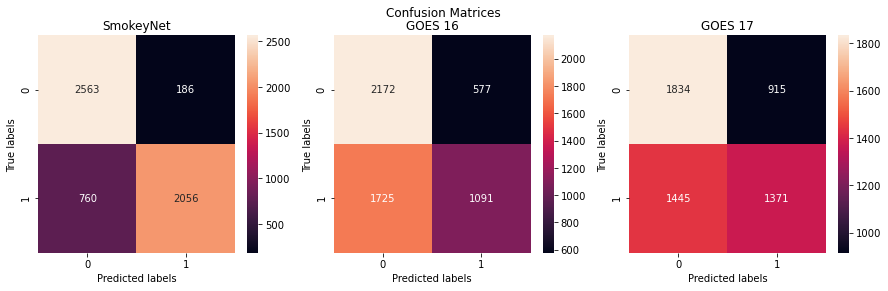

<Figure size 720x2880 with 0 Axes>

In [220]:
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

# print (help(ConfusionMatrixDisplay))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Confusion Matrices')
plt.figure(figsize=[10,40])

sn.heatmap(confusion_matrix(image_labels, smokeynet_preds), annot=True, fmt='g', ax=ax1)
sn.heatmap(confusion_matrix(image_labels, goes16_preds), annot=True, fmt='g', ax=ax2)
sn.heatmap(confusion_matrix(image_labels, goes17_preds), annot=True, fmt='g', ax=ax3)

# labels, title and ticks
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels') 
ax1.set_title('SmokeyNet') 
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels') 
ax2.set_title('GOES 16')
ax3.set_xlabel('Predicted labels')
ax3.set_ylabel('True labels') 
ax3.set_title('GOES 17')
# plt.show()

In [221]:
# smokeynet baseline precision, recall, F1
precision_recall_fscore_support(image_labels, smokeynet_preds, average = 'binary')

(0.9170383586083853, 0.7301136363636364, 0.8129695531830763, None)

In [222]:
# goes16 baseline precision, recall, F1
precision_recall_fscore_support(image_labels, goes16_preds, average = 'binary')

(0.6540767386091128, 0.3874289772727273, 0.48661909009812676, None)

In [223]:
# goes17 baseline precision, recall, F1
precision_recall_fscore_support(image_labels, goes17_preds, average = 'binary')

(0.5997375328083989, 0.48686079545454547, 0.537436299490396, None)

In [224]:
#hard voting ensemble precision, recall, F1
precision_recall_fscore_support(image_labels, hard_vote_ensemble_preds, average = 'binary')

(0.6977370689655172, 0.4598721590909091, 0.5543664383561644, None)

## 2) Weighted Voting Ensemble Model Accuracies

In [225]:
# weighted average voting

#Voting weights based off of the accuracies of the baseline SmokeyNet, WFABBA GOES-16, & WFABBA GOES-17 models
# smokeynet_weight = 0.7797790994052677
# goes16_weight = 0.513338997451147
# goes17_weight = 0.5634664401019541

smokeynet_weight = 0.8300089847259658
goes16_weight = 0.5268643306379155
goes17_weight = 0.5769991015274034

master_copy_df["weighted_avg"]  = \
    ((smokeynet_weight * smokeynet_preds) + (goes16_weight * goes16_preds) + (goes17_weight * goes17_preds)) \
    / (smokeynet_weight + goes16_weight + goes17_weight)

# voting threshold 0.2
master_copy_df["thresh2"] = master_copy_df["weighted_avg"] >= 0.2
master_copy_df["thresh2"] = master_copy_df["thresh2"].astype(int)

# voting threshold 0.3
master_copy_df["thresh3"] = master_copy_df["weighted_avg"] >= 0.3
master_copy_df["thresh3"] = master_copy_df["thresh3"].astype(int)

# voting threshold 0.4
master_copy_df["thresh4"] = master_copy_df["weighted_avg"] >= 0.4
master_copy_df["thresh4"] = master_copy_df["thresh4"].astype(int)

# voting threshold 0.5
master_copy_df["thresh5"] = master_copy_df["weighted_avg"] >= 0.5
master_copy_df["thresh5"] = master_copy_df["thresh5"].astype(int)

# voting threshold 0.6
master_copy_df["thresh6"] = master_copy_df["weighted_avg"] >= 0.6
master_copy_df["thresh6"] = master_copy_df["thresh6"].astype(int)

# voting threshold 0.7
master_copy_df["thresh7"] = master_copy_df["weighted_avg"] >= 0.7
master_copy_df["thresh7"] = master_copy_df["thresh7"].astype(int)

master_copy_df

,index,Unnamed: 0,timestamp,camera_name,image_gt,smokeynet_pred,image_prob,type,WFABBA_GOES16_timestamp_converted_rounded,WFABBA_GOES16_geometry,...,final_vote,majority_vote_pred,file,weighted_avg,thresh2,thresh3,thresh4,thresh5,thresh6,thresh7
81,0,14143,2019-06-10 19:43:00+00:00,bh-w-mobo-c,0.0,0.0,0.036438,test,NaN,NaN,...,0.0,0.0,../../data/processed/wfabba_sliding_window_new...,0.000000,0,0,0,0,0,0
82,1,14144,2019-06-10 19:44:00+00:00,bh-w-mobo-c,0.0,0.0,0.036499,test,NaN,NaN,...,0.0,0.0,../../data/processed/wfabba_sliding_window_new...,0.000000,0,0,0,0,0,0
83,2,14145,2019-06-10 19:45:00+00:00,bh-w-mobo-c,0.0,0.0,0.041779,test,NaN,NaN,...,0.0,0.0,../../data/processed/wfabba_sliding_window_new...,0.000000,0,0,0,0,0,0
84,3,14146,2019-06-10 19:46:00+00:00,bh-w-mobo-c,0.0,0.0,0.045441,test,NaN,NaN,...,0.0,0.0,../../data/processed/wfabba_sliding_window_new...,0.000000,0,0,0,0,0,0
85,4,14147,2019-06-10 19:47:00+00:00,bh-w-mobo-c,0.0,0.0,0.041626,test,NaN,NaN,...,0.0,0.0,../../data/processed/wfabba_sliding_window_new...,0.000000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10856,146,168290,2019-09-25 20:50:00+00:00,wc-s-mobo-c,1.0,0.0,0.048492,test,NaN,NaN,...,1.0,0.0,../../data/processed/wfabba_sliding_window_new...,0.298365,1,0,0,0,0,0
10857,147,168291,2019-09-25 20:51:00+00:00,wc-s-mobo-c,1.0,0.0,0.040527,test,NaN,NaN,...,1.0,0.0,../../data/processed/wfabba_sliding_window_new...,0.298365,1,0,0,0,0,0
10858,148,168292,2019-09-25 20:52:00+00:00,wc-s-mobo-c,1.0,0.0,0.046112,test,NaN,NaN,...,1.0,0.0,../../data/processed/wfabba_sliding_window_new...,0.298365,1,0,0,0,0,0
10859,149,168293,2019-09-25 20:53:00+00:00,wc-s-mobo-c,1.0,0.0,0.049866,test,NaN,NaN,...,1.0,0.0,../../data/processed/wfabba_sliding_window_new...,0.298365,1,0,0,0,0,0


### 0.2 voting threshold accuracy, precision, recall, F1

In [226]:
acc_thresh2 = accuracy_score(image_labels, master_copy_df["thresh2"])

In [227]:
p_thresh2, r_thresh2, f_thresh2, s_thresh2 = precision_recall_fscore_support(image_labels, master_copy_df["thresh2"], average = 'binary')

### 0.3 voting threshold accuracy, precision, recall, F1

In [228]:
acc_thresh3 = accuracy_score(image_labels, master_copy_df["thresh3"])

In [229]:
p_thresh3, r_thresh3, f_thresh3, s_thresh3 = precision_recall_fscore_support(image_labels, master_copy_df["thresh3"], average = 'binary')

### 0.4 voting threshold accuracy, precision, recall, F1

In [230]:
acc_thresh4 = accuracy_score(image_labels, master_copy_df["thresh4"])

In [231]:
p_thresh4, r_thresh4, f_thresh4, s_thresh4 = precision_recall_fscore_support(image_labels, master_copy_df["thresh4"], average = 'binary')

### 0.5 voting threshold accuracy, precision, recall, F1

In [232]:
acc_thresh5 = accuracy_score(image_labels, master_copy_df["thresh5"])

In [233]:
p_thresh5, r_thresh5, f_thresh5, s_thresh5 = precision_recall_fscore_support(image_labels, master_copy_df["thresh5"], average = 'binary')

### 0.6 voting threshold accuracy, precision, recall, F1

In [234]:
acc_thresh6 = accuracy_score(image_labels, master_copy_df["thresh6"])

In [235]:
p_thresh6, r_thresh6, f_thresh6, s_thresh6 = precision_recall_fscore_support(image_labels, master_copy_df["thresh6"], average = 'binary')

### 0.7 voting threshold accuracy, precision, recall, F1

In [236]:
acc_thresh7 = accuracy_score(image_labels, master_copy_df["thresh7"])

In [237]:
p_thresh7, r_thresh7, f_thresh7, s_thresh7 = precision_recall_fscore_support(image_labels, master_copy_df["thresh7"], average = 'binary')

### Ploting Accuracy & F1 of Weighted Vote Ensemble with Various Thresholds

In [238]:
thresholds = [0.2,0.3,0.4,0.5,0.6,0.7]
accuracies =  [acc_thresh2, acc_thresh3, acc_thresh4, acc_thresh5, acc_thresh6, acc_thresh7]
f1s = [f_thresh2, f_thresh3, f_thresh4, f_thresh5, f_thresh6, f_thresh7]

In [27]:
accuracies

[0.7636032757051865,
 0.7856232939035487,
 0.7856232939035487,
 0.6303912647861692,
 0.6280254777070063,
 0.6280254777070063]

In [28]:
f1s

[0.7699663538161856,
 0.7792353823088455,
 0.7792353823088455,
 0.47123145014319184,
 0.44244408074195307,
 0.44244408074195307]

In [239]:
from prettytable import PrettyTable
import numpy as np

results_table = PrettyTable(['threshold', 'accuracy', 'f1', 'max_acc', 'max_f1'])
max_acc_ind = accuracies.index(max(accuracies))
max_acc = ['' if x != max_acc_ind else 'max' for x in range(len(accuracies))]
max_f1_ind = f1s.index(max(f1s))
max_f1 = ['' if x != max_f1_ind else 'max' for x in range(len(f1s))]
results_table.add_rows(list(zip(thresholds, accuracies, f1s, max_acc, max_f1)))
print (results_table)

+-----------+--------------------+--------------------+---------+--------+
| threshold |      accuracy      |         f1         | max_acc | max_f1 |
+-----------+--------------------+--------------------+---------+--------+
|    0.2    | 0.7243486073674753 | 0.7551085568326947 |         |        |
|    0.3    | 0.7739442946990117 | 0.7813694820994093 |   max   |  max   |
|    0.4    | 0.7739442946990117 | 0.7813694820994093 |         |        |
|    0.5    | 0.6258760107816712 | 0.5543664383561644 |         |        |
|    0.6    | 0.6819407008086253 | 0.5548289738430583 |         |        |
|    0.7    | 0.6819407008086253 | 0.5548289738430583 |         |        |
+-----------+--------------------+--------------------+---------+--------+


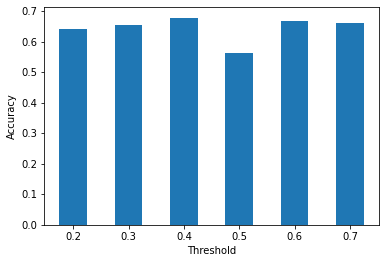

In [68]:
x_range = range(len(thresholds))
plt.bar(x_range, accuracies, width = 0.5)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.xticks(x_range, thresholds)
plt.show()

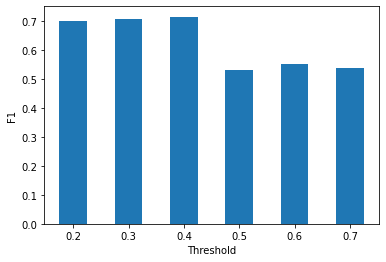

In [69]:
x_range = range(len(thresholds))
plt.bar(x_range, f1s, width = 0.5)
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.xticks(x_range, thresholds)
plt.show()